In [1]:
import os
import sys
import warnings
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /root/sr-press


In [2]:
from socceraction.data.statsbomb import StatsBombLoader
from statsbombpy import sb
from express.databases import SQLiteDatabase
from express.visualization import plot_action
from express.utils import add_names

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
SBL = StatsBombLoader(root=os.path.join(base_path, "open-data/data"), getter="local")
competition = sb.competitions()

# HTTPError: 404 Client Error: Not Found for ur
Error_competition = [(11, 90), (7, 235), (7, 108), (44, 107)] # La-Liga 20/21, Ligue1 21/22, Ligue1 22/23 
competition = competition[~competition[["competition_id", "season_id"]].apply(tuple, axis=1).isin(Error_competition)] # HTTPError: 404 Client Error: Not Found for ur
competition = competition[(competition["match_available_360"].notna()) & (competition["competition_gender"] == "male")]
competition

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
29,43,106,International,FIFA World Cup,male,False,True,2022,2024-05-15T10:23:32.854925,2024-06-11T11:30:50.462448,2024-06-11T11:30:50.462448,2024-05-15T10:23:32.854925
68,55,282,Europe,UEFA Euro,male,False,True,2024,2024-07-15T15:48:50.315500,2024-07-15T15:52:24.778809,2024-07-15T15:52:24.778809,2024-07-15T15:48:50.315500
69,55,43,Europe,UEFA Euro,male,False,True,2020,2024-04-16T12:44:40.558402,2024-04-16T12:47:18.505110,2024-04-16T12:47:18.505110,2024-04-16T12:44:40.558402


In [ ]:
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in tqdm(competition.itertuples())
]).reset_index(drop=True)

train_games = games[
    ((games['competition_id'] == 9) & (games['season_id'] == 281)) |          # Bundesliga
    ((games['competition_id'] == 55) & (games['season_id'].isin([282, 43])))  # UEFA Euro 2020, 2024
]

test_games = games[
    ((games['competition_id'] == 43) & (games['season_id'] == 106)) # World Cup
]

print(train_games.shape, test_games.shape)

0it [00:00, ?it/s]

(136, 12) (64, 12)


In [7]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7fb4b03ab4f0>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7fb4b0da4f10>


In [ ]:
# Loading Time: 10m

for _, game in tqdm(train_games.iterrows(), desc="train_game loading"):
    dataset = {"getter": "local", 
                "competition_id": game["competition_id"], 
                "season_id": game["season_id"], 
                "game_id": game["game_id"],
                "root": os.path.join(base_path, "open-data/data")}
    
    train_db.import_data(**dataset)

for _, game in tqdm(test_games.iterrows(), desc="test_game loading"):
    dataset = {"getter": "local", 
                "competition_id": game["competition_id"], 
                "season_id": game["season_id"], 
                "game_id": game["game_id"],
                "root": os.path.join(base_path, "open-data/data")}
    
    test_db.import_data(**dataset)

train_game loading: 0it [00:00, ?it/s]

test_game loading: 0it [00:00, ?it/s]

In [13]:
test_db.games()

,season_id,competition_id,game_day,game_date,home_team_id,away_team_id,competition_stage,home_score,away_score,venue,referee
game_id,,,,,,,,,,,
3857254,106,43,1,2022-11-22 15:00:00,776,777,Group Stage,0,0,Education City Stadium,César Arturo Ramos Palazuelos
3857255,106,43,3,2022-12-01 21:00:00,778,772,Group Stage,2,1,Sheikh Khalifa International Stadium,Victor Miguel de Freitas Gomes
3857256,106,43,3,2022-12-02 21:00:00,786,773,Group Stage,2,3,Stadium 974,Fernando Andrés Rapallini
3857257,106,43,3,2022-11-30 17:00:00,792,776,Group Stage,1,0,Al Janoub Stadium,Mustapha Ghorbal
3857258,106,43,1,2022-11-24 21:00:00,781,786,Group Stage,2,0,Lusail Stadium,Alireza Faghani
...,...,...,...,...,...,...,...,...,...,...,...
3869486,106,43,5,2022-12-10 17:00:00,788,780,Quarter-finals,1,0,Al Thumama Stadium,Facundo Tello Figueroa
3869519,106,43,6,2022-12-13 21:00:00,779,785,Semi-finals,3,0,Lusail Stadium,Daniele Orsato
3869552,106,43,6,2022-12-14 21:00:00,771,788,Semi-finals,2,0,Al Bayt Stadium,César Arturo Ramos Palazuelos


In [14]:
game_id = 3857254

df_actions = add_names(test_db.actions(game_id)).reset_index()
df_actions.head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3857254,0,f401b014-4d54-404e-aa65-67e00ea64144,1,0.361,776,6302,52.0625,34.425,50.3125,...,From Kick Off,0,0.219126,"{'pass': {'recipient': {'id': 3043, 'name': 'C...","[[43.177205387862, 5.5121017012466424], [21.82...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right
1,3857254,1,4ce2daaf-26cb-4421-9edd-d32c2da252aa,1,0.580,776,3043,50.3125,37.315,51.4500,...,From Kick Off,0,0.979460,"{'carry': {'end_location': [59.3, 40.7]}}","[[41.673244322206436, 6.197435489493152], [20....",1,"[{'teammate': True, 'actor': False, 'keeper': ...",dribble,success,foot
2,3857254,2,95ee43ac-863e-481f-81d5-8df75f8526ad,1,1.560,776,3043,51.4500,33.830,65.0125,...,From Kick Off,0,1.255742,"{'pass': {'recipient': {'id': 17042, 'name': '...","[[42.6049539311459, 4.5048722886327965], [21.6...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right
3,3857254,3,0891ccef-0607-4fd5-8947-6356da847ee5,1,2.816,776,17042,65.0125,23.970,67.2875,...,From Kick Off,1,0.976961,"{'carry': {'end_location': [77.4, 54.9]}}","[[48.315350004491414, 7.761611553707404], [33....",1,"[{'teammate': True, 'actor': False, 'keeper': ...",dribble,success,foot
4,3857254,4,5af23d18-48fa-4708-8df8-02134574b7de,1,3.176,777,23910,69.3875,23.800,69.3875,...,From Kick Off,0,0.695959,{},"[[99.8327620665036, 68.0], [71.38467021012661,...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pressing,fail,foot


909 914
Skip action due to missing freeze frame: 467
Skip action due to missing freeze frame: 468
Skip action due to missing freeze frame: 469
Skip action due to missing freeze frame: 470
Skip action due to missing freeze frame: 471


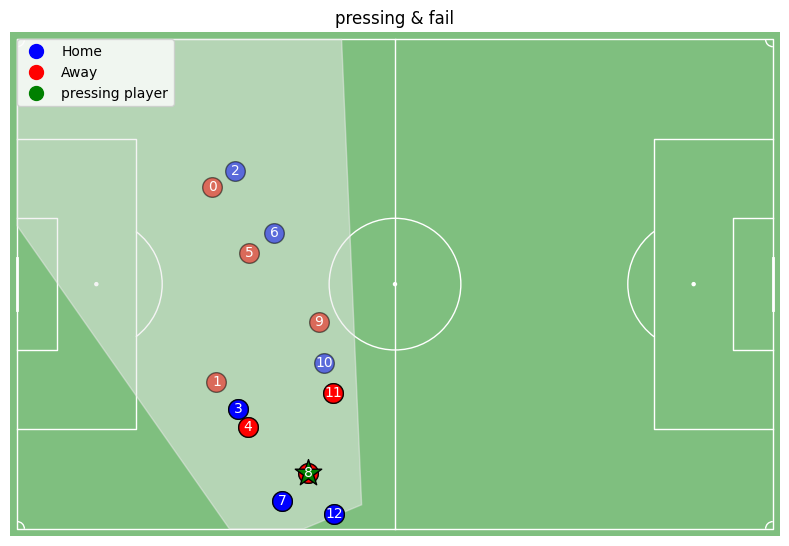

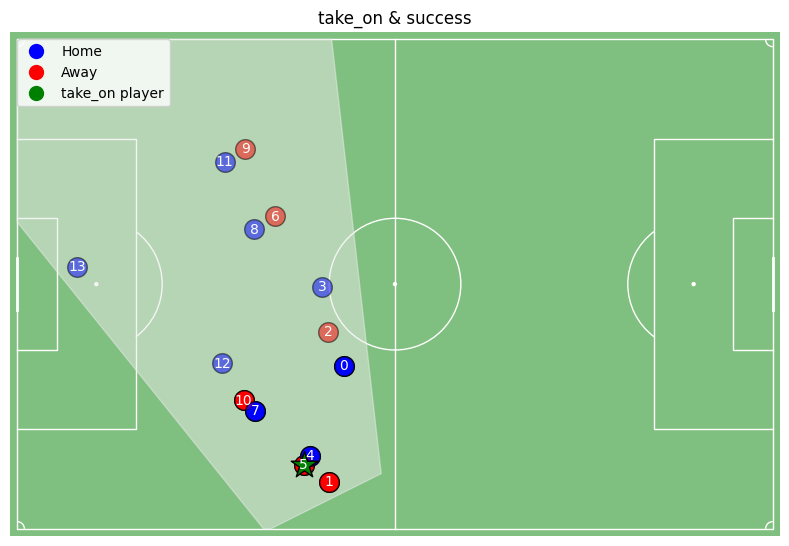

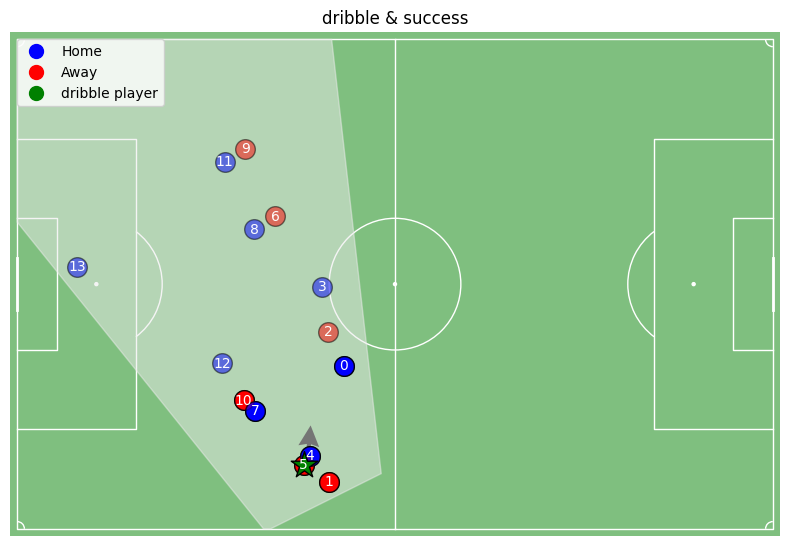

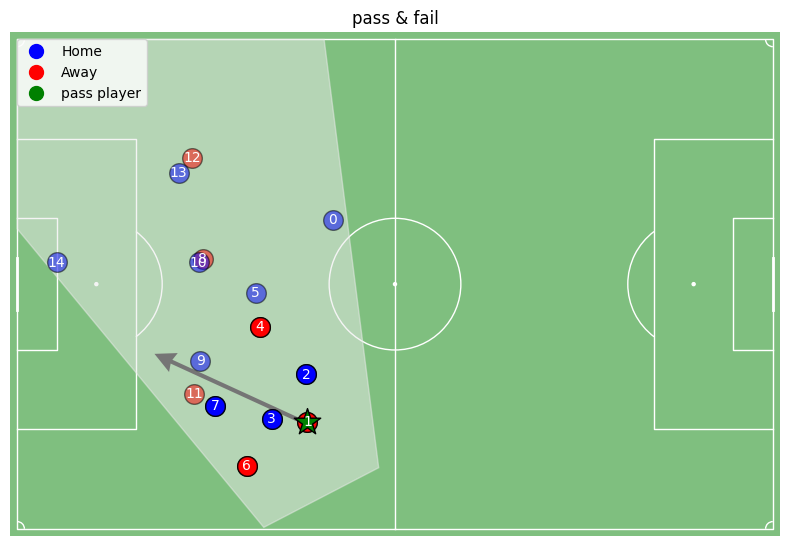

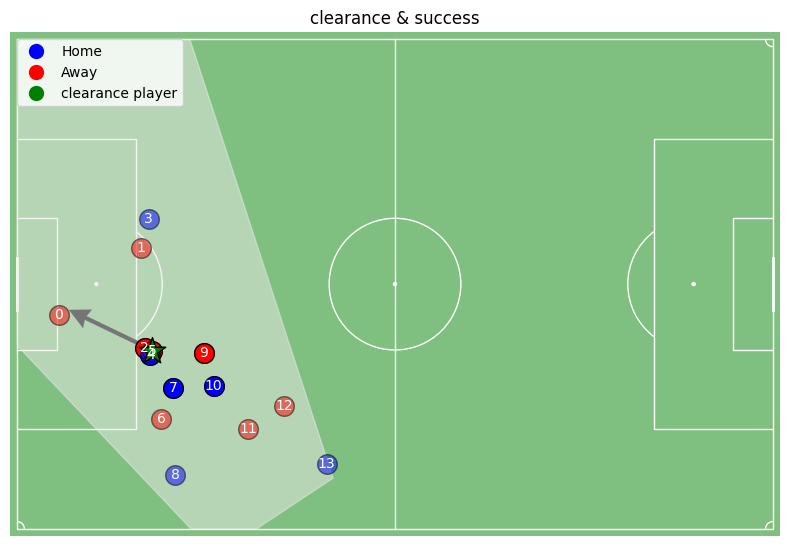

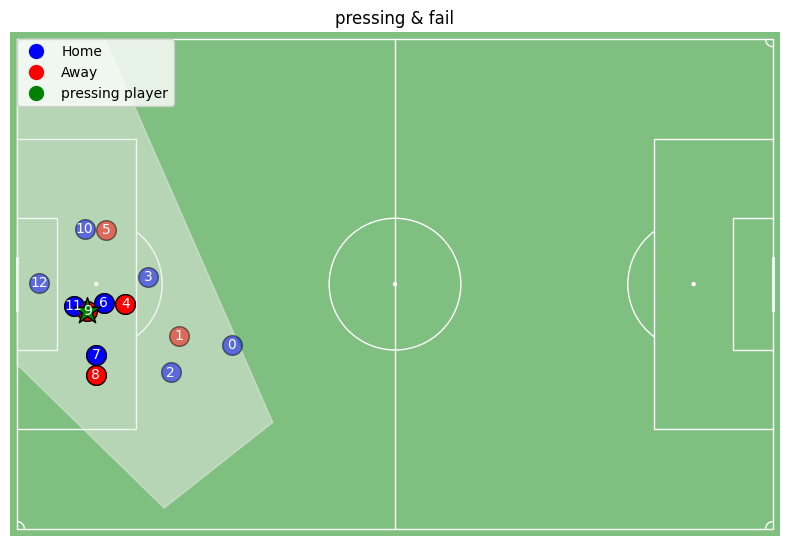

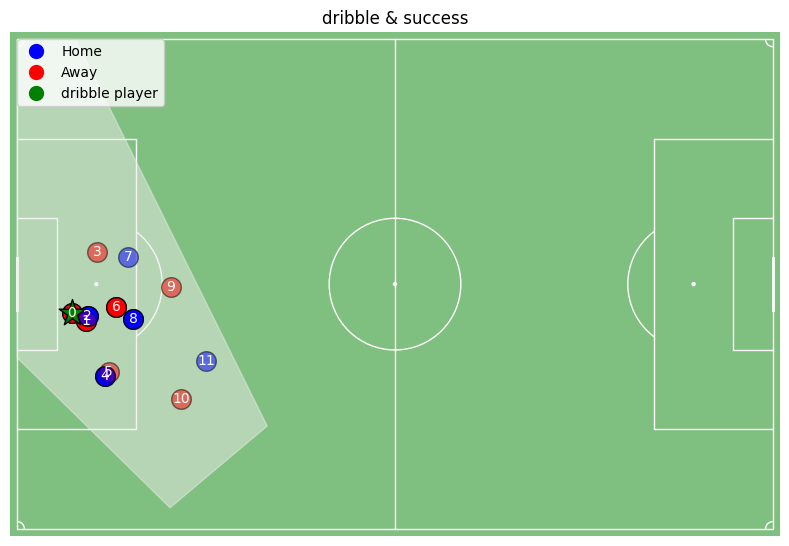

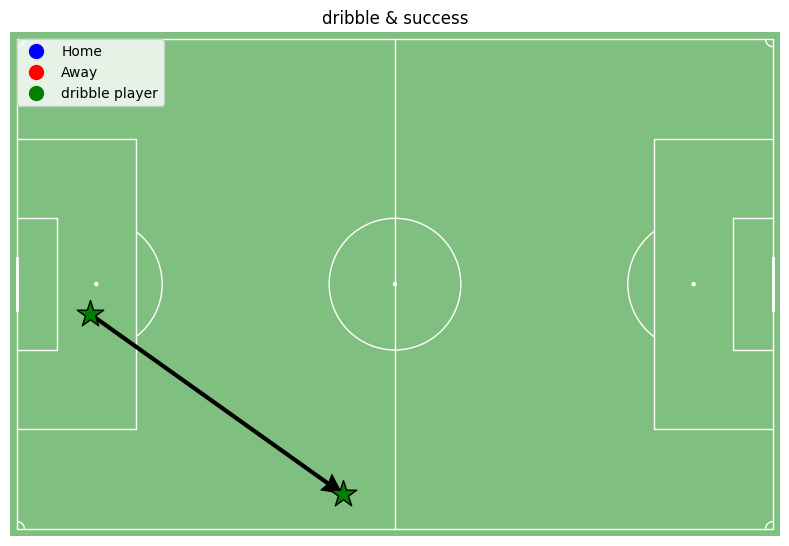

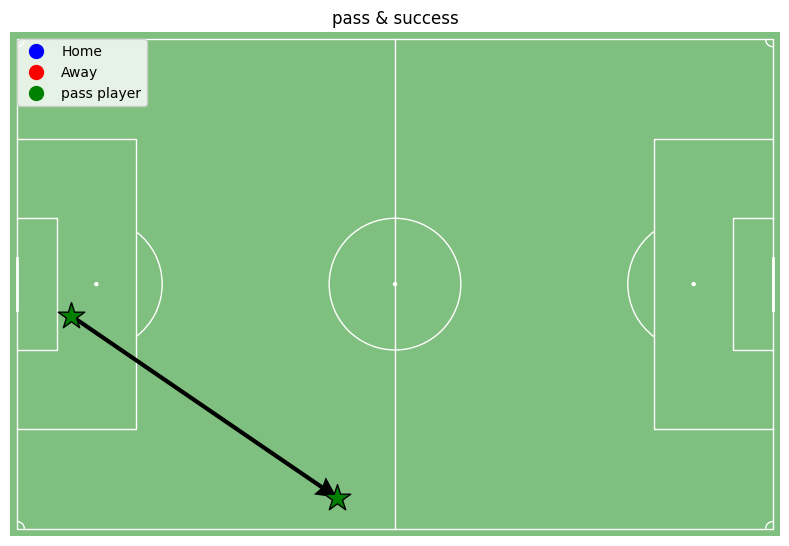

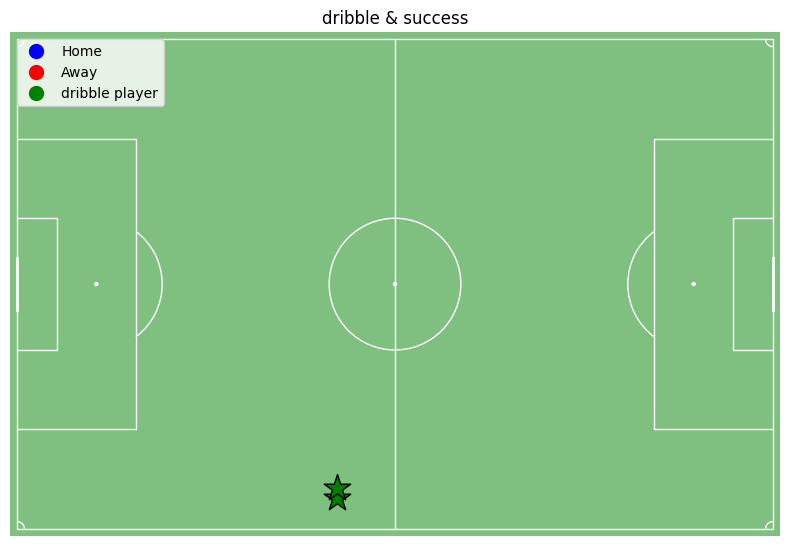

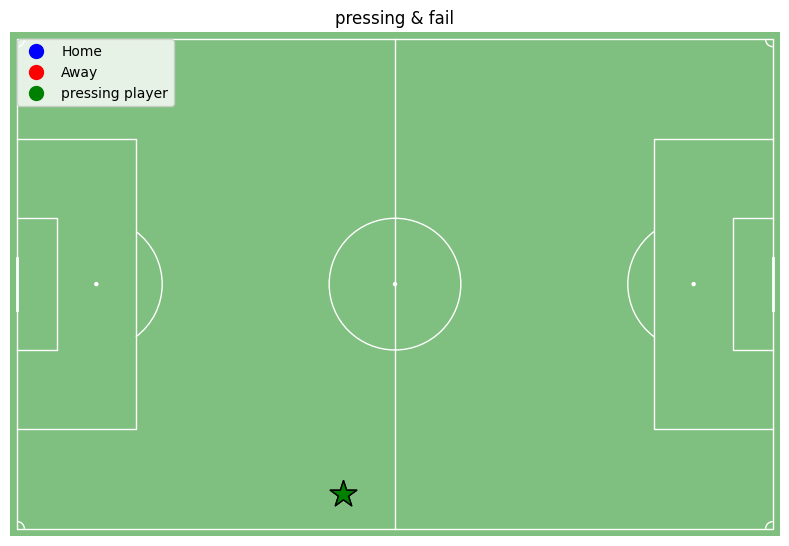

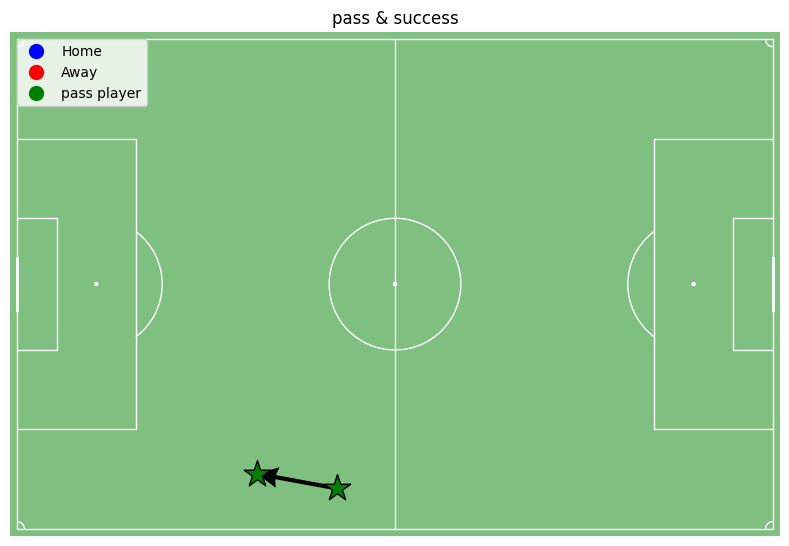

In [16]:
pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[62]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = 3788741)

print(home_team_id, away_team_id)

for idx in range(pressure_idx-10, pressure_idx+2):
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame:",idx)
        plot_action(df_actions.loc[idx], home_team_id=home_team_id, show_visible_area=False)
    else:
        # plot_action: 데이터의 위치 정보는 홈팀은 left->right, 원정팀은 left<-right인 상태이다.
        plot_action(df_actions.loc[idx], home_team_id=home_team_id)